## Importing Packages and Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')       #to get access to my files through Google Drive

Mounted at /content/drive


In [2]:
!date

import aesara.tensor as at
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter      #importing packages

%matplotlib inline            

Mon Dec 19 19:10:52 UTC 2022


In [3]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = True          #settings

In [4]:
df_all = pd.read_csv(f'/content/drive/My Drive/MIT Year 4/Fall Semester/9.66/9.66 Final Project/NFL_games_data_2022.csv', index_col=0)
df_all.tail()       #loading and looking at data from 2022 season

,home_team,away_team,home_score,away_score
207,Arizona Cardinals,New England Patriots,13,27
208,Seattle Seahawks,San Francisco 49ers,13,21
209,Minnesota Vikings,Indianapolis Colts,39,36
210,Cleveland Browns,Baltimore Ravens,13,3
211,Buffalo Bills,Miami Dolphins,32,29


In [5]:
len(df_all['home_team'].unique())    #checking team names (should be length 32)

32

## Analysis of Data/Data Exploration

In [6]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])      #creating a column to see how much the winner usually wins by 

In [7]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]      #creating a column to see how much the home team usually wins by

In [8]:
df_all['season'] = 2022       #adding season column to be able to re-use code from original data exploration

In [9]:
df_all.describe()       #data summary

,home_score,away_score,difference,difference_non_abs,season
count,212.000000,212.000000,212.000000,212.00000,212.0
mean,22.938679,21.141509,9.457547,1.79717,2022.0
std,8.717309,9.694322,7.711203,12.08663,0.0
min,3.000000,0.000000,0.000000,-37.00000,2022.0
25%,17.000000,15.000000,3.000000,-5.00000,2022.0
50%,23.000000,20.500000,7.000000,2.00000,2022.0
75%,28.000000,27.000000,14.000000,8.00000,2022.0
max,54.000000,48.000000,37.000000,35.00000,2022.0


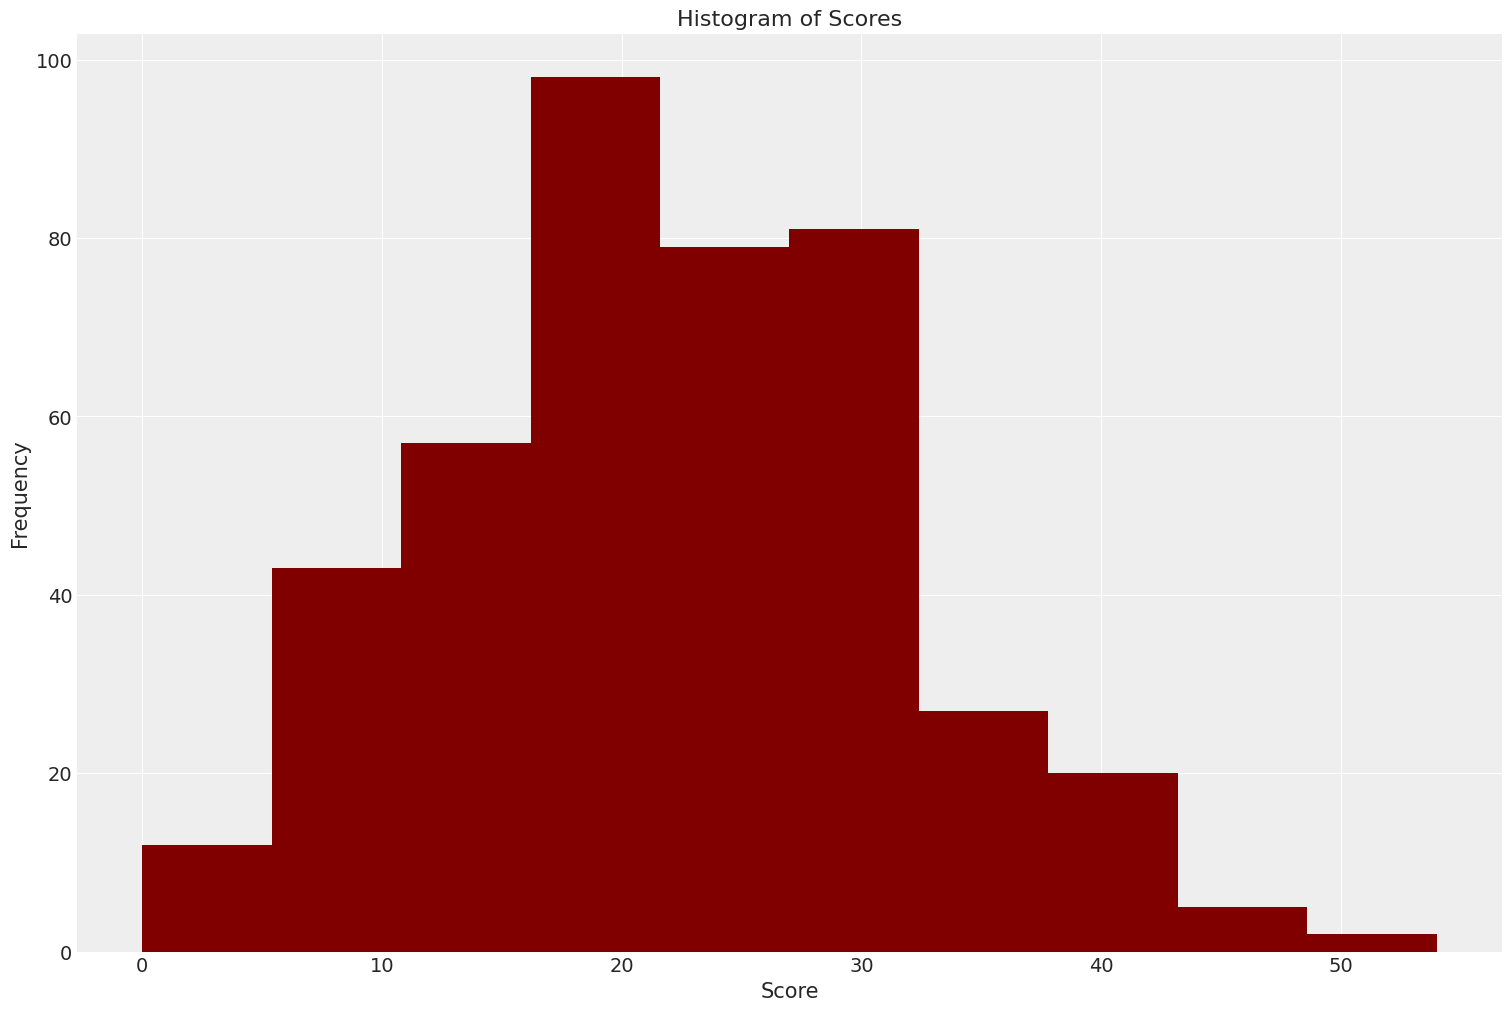

Score mean :  22.04009433962264
Score standard deviation :  9.240793275929212


In [10]:
fig = plt.figure(figsize = (15, 10))

scores = list(df_all['away_score']) + list(df_all['home_score'])
 
# creating a bar plot/histogram
plt.hist(scores, color ='maroon',)
 
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Histogram of Scores")
plt.show()

print('Score mean : ', str(np.mean(scores)))
print('Score standard deviation : ', np.std(scores))      #printing the histogram of score values from all teams in the data, along with its mean and standard deviation      

1.7971698113207548
146.08662702316016


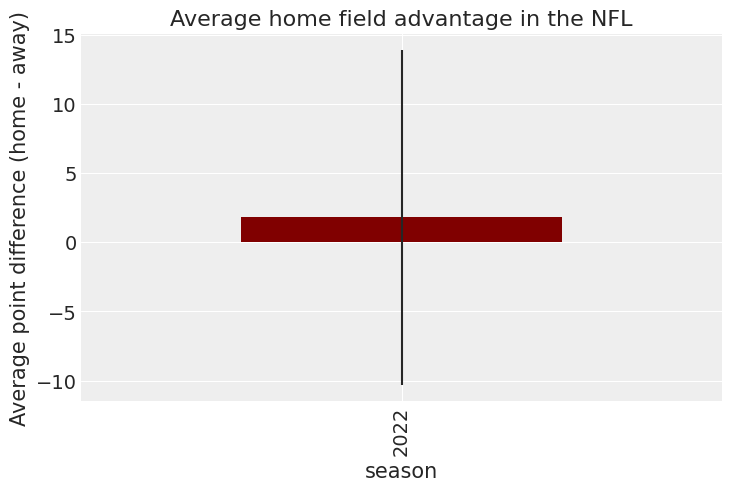

In [13]:
(
    df_all.groupby("season")["difference_non_abs"]
    .mean()
    .plot(
        color ='maroon',
        kind="bar",
        title="Average home field advantage in the NFL",
        yerr=df_all.groupby("season")["difference_non_abs"].std(),
    )
    .set_ylabel("Average point difference (home - away)")
);    

#the mean and variance don't necessarily make sense as a difference of Poisson variables, could be future work

print(df_all['difference_non_abs'].mean())
print(df_all['difference_non_abs'].var())

In [28]:
df_all.pivot_table("difference_non_abs", "home_team", "season")       #showing un-adjusted (for team strength) home field advantage numbers

season,2022
home_team,
Arizona Cardinals,-9.875000
Atlanta Falcons,2.285714
Baltimore Ravens,1.500000
Buffalo Bills,13.571429
Carolina Panthers,2.142857
Chicago Bears,-1.000000
Cincinnati Bengals,10.666667
Cleveland Browns,3.000000
Dallas Cowboys,10.875000


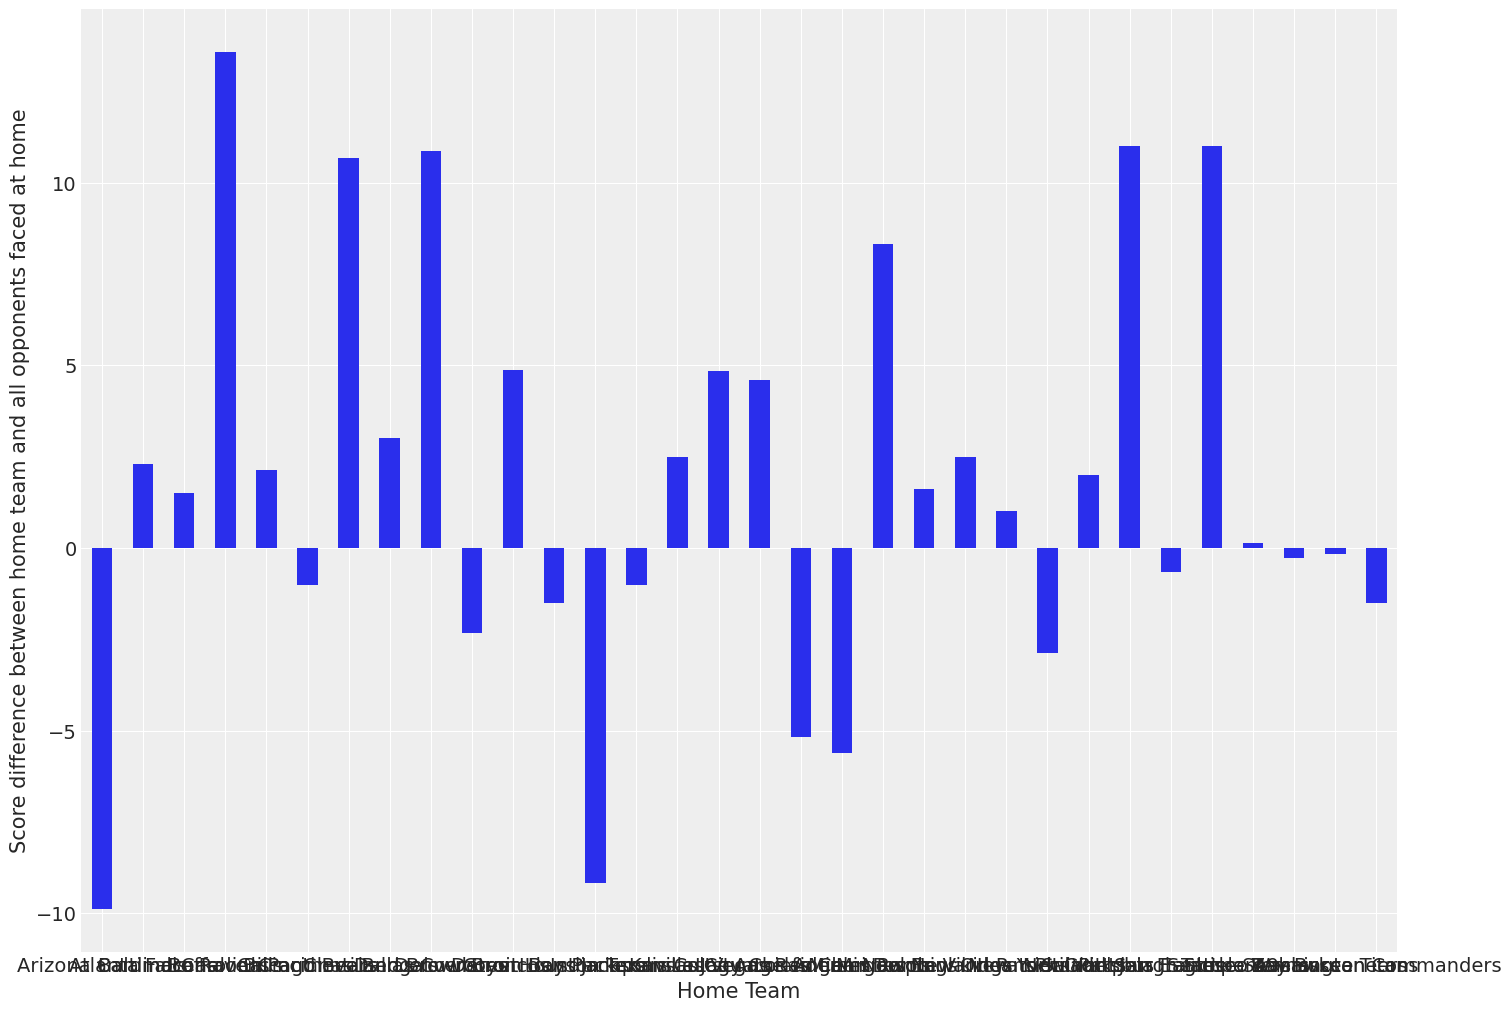

In [29]:
(
    df_all.pivot_table("difference_non_abs", "home_team")
    .rename_axis("Home Team")
    .plot(kind="bar", rot=0, legend=False, figsize=(15, 10))
    .set_ylabel("Score difference between home team and all opponents faced at home")
);                                                                  #visualizing the table above

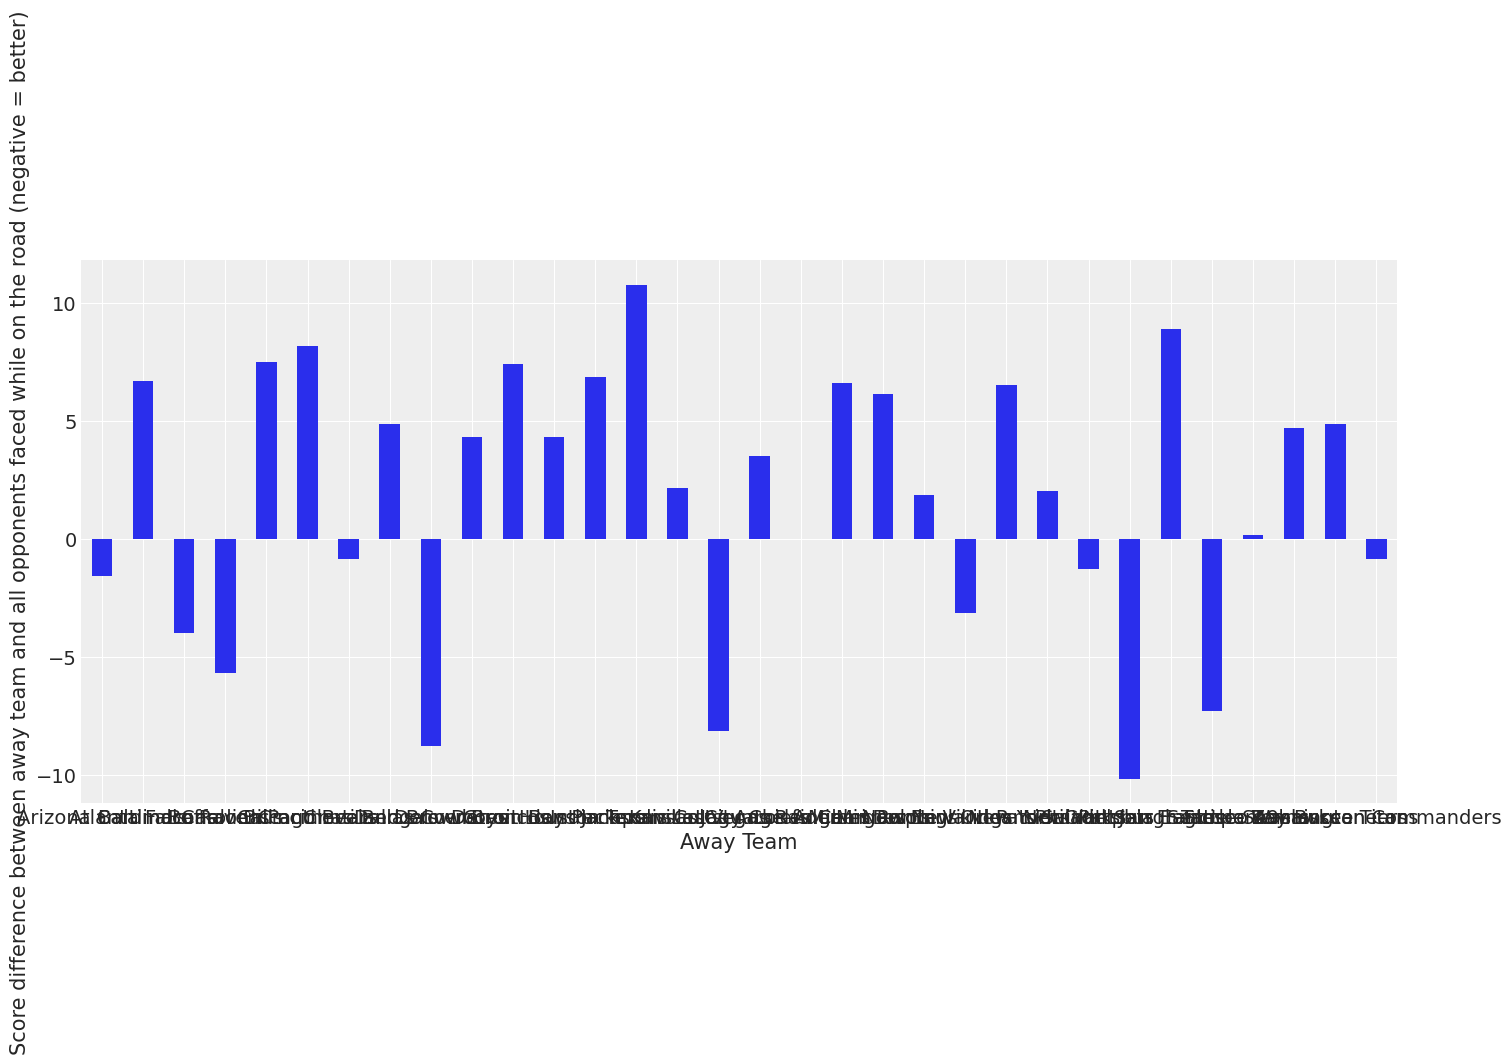

In [30]:
(
    df_all.pivot_table("difference_non_abs", "away_team")
    .rename_axis("Away Team")
    .plot(kind="bar", rot=0, legend=False, figsize=(15, 10))
    .set_ylabel("Score difference between away team and all opponents faced while on the road (negative = better)")
);
#visualizing the opposite of home field advantge, the effect of playing away. again, these are un-adjusted numbers, the real home field advantage is not as severe as this, and it will be 
#shown later in the code
#between this plot and the previous one, you can see that NFL teams do indeed have a home field advantage, which is a bit more than one would expect

In [31]:
result = {'team' : [], 'home field advantage' : []}
for team in df_all['home_team'].unique(): 
  home_df = df_all.query("home_team == '" + str(team) + "'")
  away_df = df_all.query("away_team == '" + str(team) + "'")
  result['team'].append(team)
  home_mean = home_df['difference_non_abs'].mean() #positive is good
  away_mean = away_df['difference_non_abs'].mean() #negative is good
  result['home field advantage'].append(home_mean + away_mean)
result                

        #seeing the un-adjusted scoring difference for teams, both home and away 

{'team': ['Los Angeles Rams',
  'Atlanta Falcons',
  'Carolina Panthers',
  'Chicago Bears',
  'Cincinnati Bengals',
  'Houston Texans',
  'Detroit Lions',
  'Washington Commanders',
  'Miami Dolphins',
  'New York Jets',
  'Arizona Cardinals',
  'Minnesota Vikings',
  'Tennessee Titans',
  'Los Angeles Chargers',
  'Dallas Cowboys',
  'Seattle Seahawks',
  'Kansas City Chiefs',
  'New York Giants',
  'Cleveland Browns',
  'Jacksonville Jaguars',
  'Baltimore Ravens',
  'New Orleans Saints',
  'Pittsburgh Steelers',
  'San Francisco 49ers',
  'Las Vegas Raiders',
  'Denver Broncos',
  'Green Bay Packers',
  'Buffalo Bills',
  'Philadelphia Eagles',
  'Indianapolis Colts',
  'New England Patriots',
  'Tampa Bay Buccaneers'],
 'home field advantage': [0.9749999999999996,
  8.952380952380953,
  9.642857142857142,
  7.142857142857142,
  9.809523809523808,
  -2.3095238095238093,
  12.275,
  -2.357142857142857,
  14.458333333333334,
  0.7142857142857142,
  -11.475,
  3.458333333333333,
  4.6

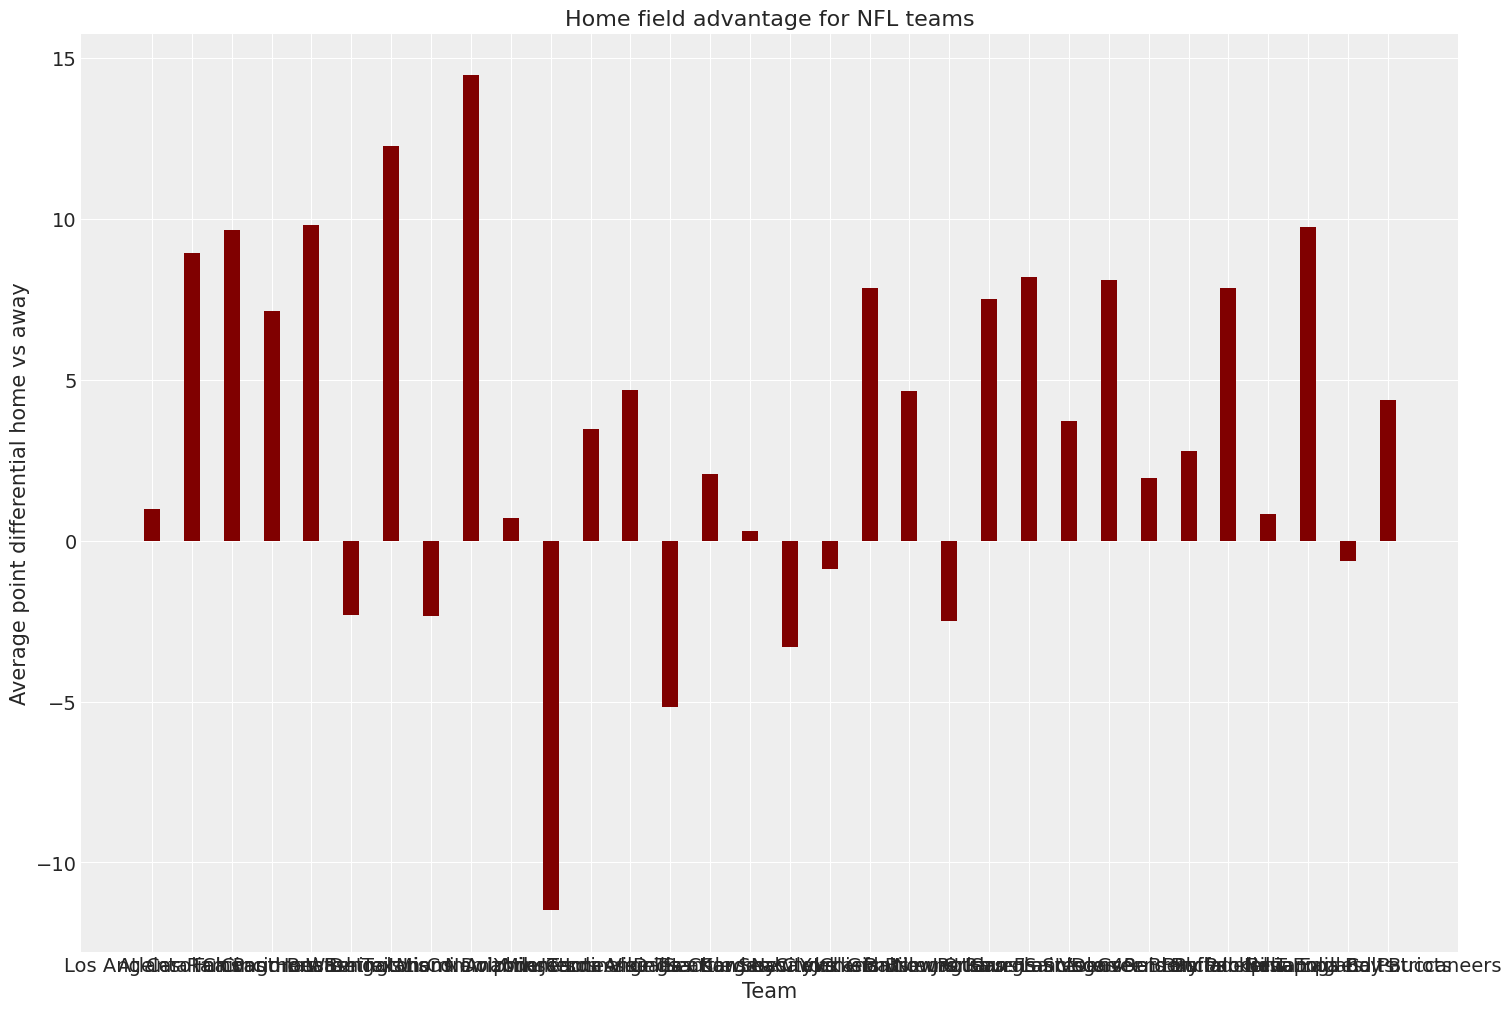

In [32]:
fig = plt.figure(figsize = (15, 10))
 
# creating the bar plot
plt.bar(result['team'], result['home field advantage'], color ='maroon',
        width = 0.4)
 
plt.xlabel("Team")
plt.ylabel("Average point differential home vs away")
plt.title("Home field advantage for NFL teams")
plt.show()

#this is a graph representing un-adjusted home field advantage

## Building the Model

In [14]:
plt.rcParams["figure.constrained_layout.use"] = True
home_idx, teams = pd.factorize(df_all["home_team"], sort=True)  
away_idx, _ = pd.factorize(df_all["away_team"], sort=True)    #putting an ID number on each team, the IDs are listed in alphabetical order
coords = {"team": teams}                                      #coords is in that same order
print(teams)

Index(['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens',
       'Buffalo Bills', 'Carolina Panthers', 'Chicago Bears',
       'Cincinnati Bengals', 'Cleveland Browns', 'Dallas Cowboys',
       'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
       'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars',
       'Kansas City Chiefs', 'Las Vegas Raiders', 'Los Angeles Chargers',
       'Los Angeles Rams', 'Miami Dolphins', 'Minnesota Vikings',
       'New England Patriots', 'New Orleans Saints', 'New York Giants',
       'New York Jets', 'Philadelphia Eagles', 'Pittsburgh Steelers',
       'San Francisco 49ers', 'Seattle Seahawks', 'Tampa Bay Buccaneers',
       'Tennessee Titans', 'Washington Commanders'],
      dtype='object')


In [15]:
with pm.Model(coords=coords) as model:
    # MutableData type allows me to enter additional prediction/testing data
    home_team = pm.MutableData("home_team", home_idx, dims="match")
    away_team = pm.MutableData("away_team", away_idx, dims="match")    #assigning IDs

    # global model parameters
    home = pm.Normal("home", mu=0, sigma=1)
    sd_off = pm.HalfNormal("sd_off", sigma=2)
    sd_def = pm.HalfNormal("sd_def", sigma=2)
    intercept = pm.Normal("intercept", mu=3, sigma=1)

    # team-specific model parameters
    off_star = pm.Normal("off_star", mu=0, sigma=sd_off, dims="team")
    def_star = pm.Normal("def_star", mu=0, sigma=sd_def, dims="team")   #distributions of offensive and defensive team strengths

    offenses = pm.Deterministic("offenses", off_star - at.mean(off_star), dims="team")    
    defenses = pm.Deterministic("defenses", def_star - at.mean(def_star), dims="team")      #offensive and defensive strengths
    home_theta = at.exp(intercept + home + offenses[home_team] + defenses[away_team])
    away_theta = at.exp(intercept + offenses[away_team] + defenses[home_team])            #loglinear combination of offense + defense + intercept ( + home)


    # likelihood of observed data
    home_points = pm.Poisson(
        "home_points",
        mu=home_theta,
        observed=df_all["home_score"],
        dims=("match"),
    )
    away_points = pm.Poisson(
        "away_points",
        mu=away_theta,
        observed=df_all["away_score"],
        dims=("match"),                     #was only able to find points data for this season, no EPA data like in the other model
    )                           
    trace = pm.sample(1000, tune=1500, cores=4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd39cc35490>,
      dtype=object)

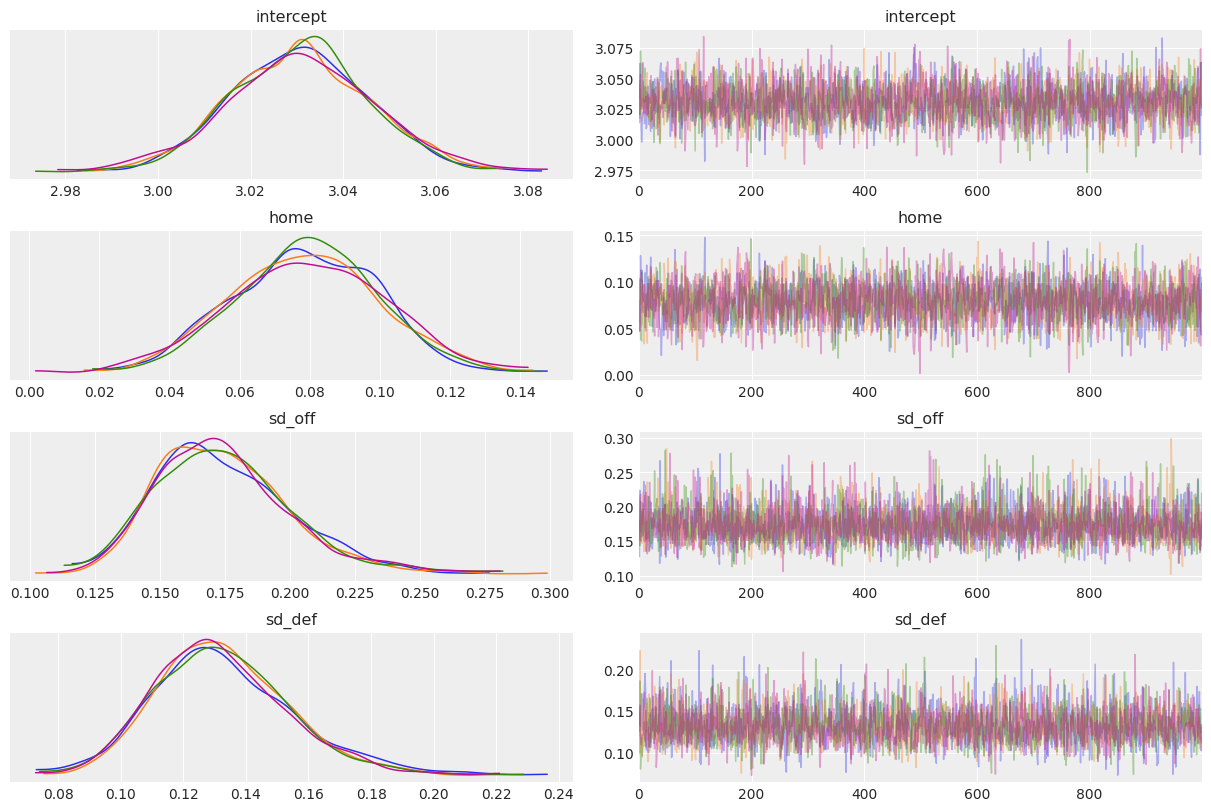

In [16]:
az.plot_trace(trace, var_names=["intercept", "home", "sd_off", "sd_def"], compact=False)       #checking for divergences

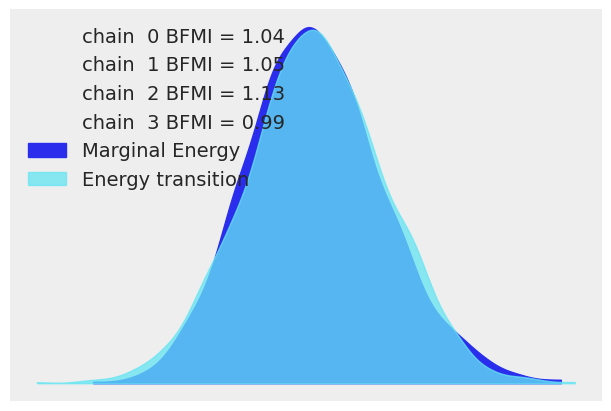

In [43]:
az.plot_energy(trace, figsize=(6, 4))     #checking for divergences

In [44]:
az.summary(trace, kind="diagnostics")     #trace data summary

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
home,0.000,0.000,2997.0,3098.0,1.0
intercept,0.000,0.000,2938.0,3061.0,1.0
off_star[Arizona Cardinals],0.001,0.001,1996.0,2024.0,1.0
off_star[Atlanta Falcons],0.002,0.001,1709.0,2349.0,1.0
off_star[Baltimore Ravens],0.001,0.001,1831.0,2421.0,1.0
...,...,...,...,...,...
defenses[San Francisco 49ers],0.001,0.001,4966.0,3032.0,1.0
defenses[Seattle Seahawks],0.001,0.001,4814.0,3034.0,1.0
defenses[Tampa Bay Buccaneers],0.001,0.001,6579.0,2523.0,1.0
defenses[Tennessee Titans],0.001,0.001,5592.0,3110.0,1.0


In [18]:
trace_hdi = az.hdi(trace)
print('offenses : ', trace_hdi["offenses"])         #alphabetical order
print('\nDefenses : ', trace_hdi["defenses"])       #looking at the HDIs of the offense/defense variables, for defenses negative is better 

offenses :  <xarray.DataArray 'offenses' (team: 32, hdi: 2)>
array([[-0.16457035,  0.04952922],
       [-0.09260438,  0.11054078],
       [-0.07320578,  0.13208713],
       [ 0.13314442,  0.32399475],
       [-0.18886976,  0.03468433],
       [-0.1214231 ,  0.09060916],
       [ 0.04882084,  0.25167021],
       [-0.03901841,  0.17139756],
       [ 0.10591321,  0.30117563],
       [-0.4583878 , -0.21145452],
       [ 0.09128522,  0.29420419],
       [-0.13253947,  0.0870963 ],
       [-0.37594274, -0.13887491],
       [-0.27528334, -0.05815996],
       [-0.08345305,  0.12127458],
       [ 0.20384239,  0.39571314],
       [-0.0546086 ,  0.15861942],
       [-0.11100601,  0.09869845],
       [-0.36120961, -0.12547941],
       [ 0.05726438,  0.25510585],
       [ 0.03164842,  0.23156716],
       [-0.12857615,  0.08164452],
       [-0.18377829,  0.0410863 ],
       [-0.17164392,  0.04850739],
       [-0.11137997,  0.10413547],
       [ 0.17810646,  0.37240479],
       [-0.26852227, -0.03928

## Results

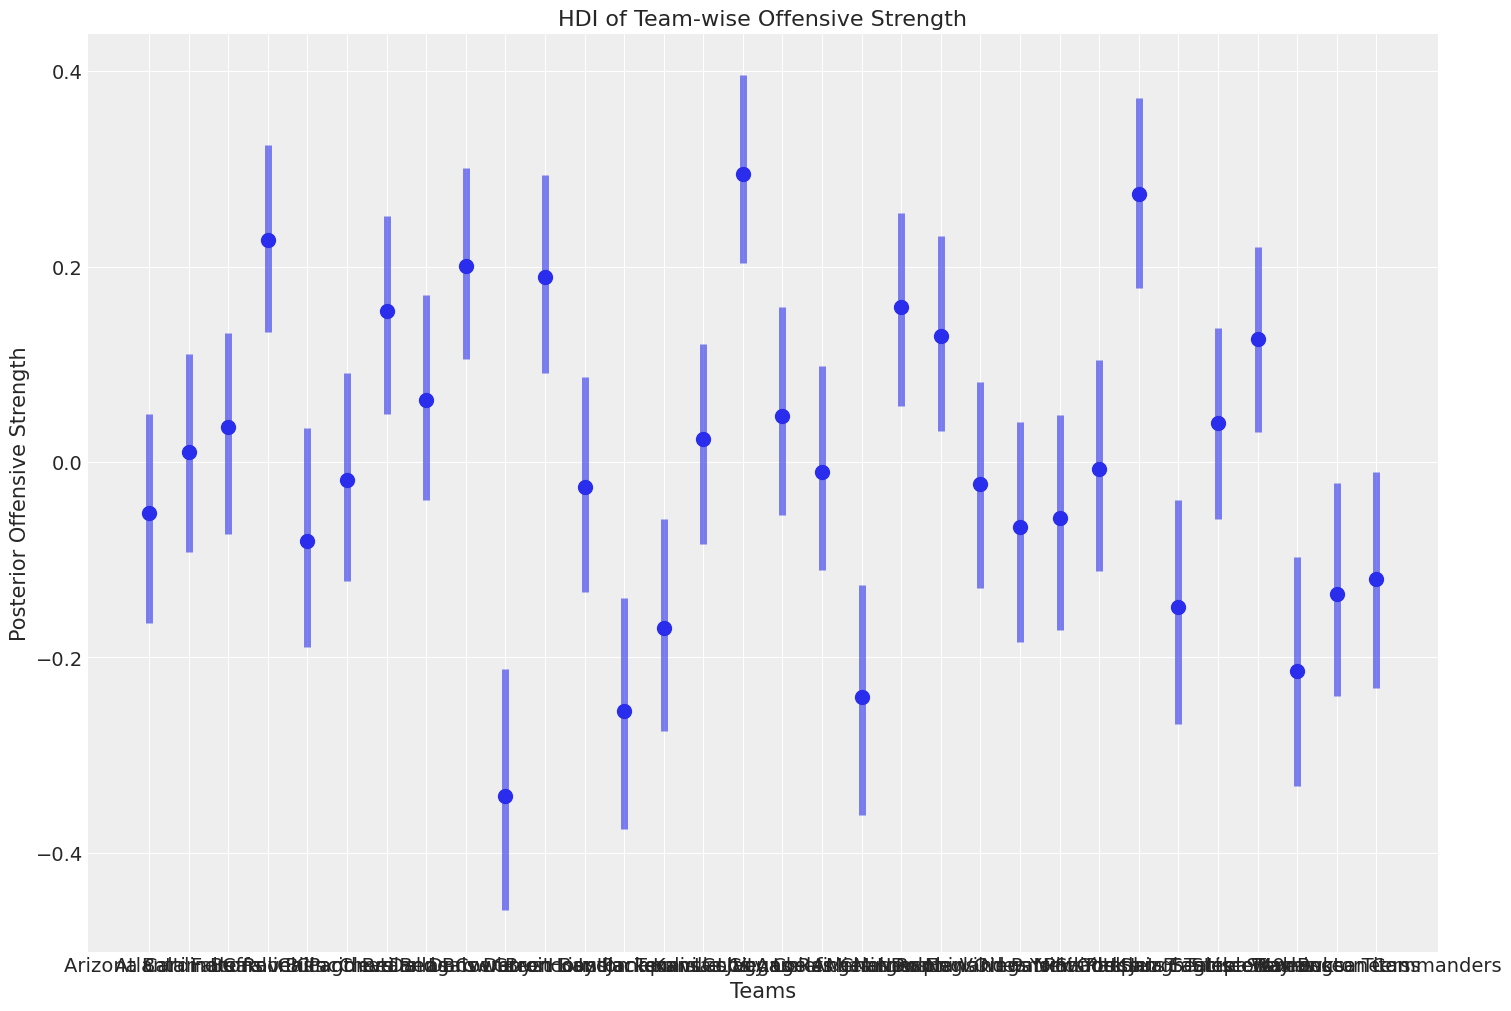

In [19]:
_, ax = plt.subplots(figsize=(15, 10))

ax.scatter(teams, trace.posterior["offenses"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["offenses"].sel({"hdi": "lower"}),
    trace_hdi["offenses"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Offensive Strength")
ax.set_title("HDI of Team-wise Offensive Strength");

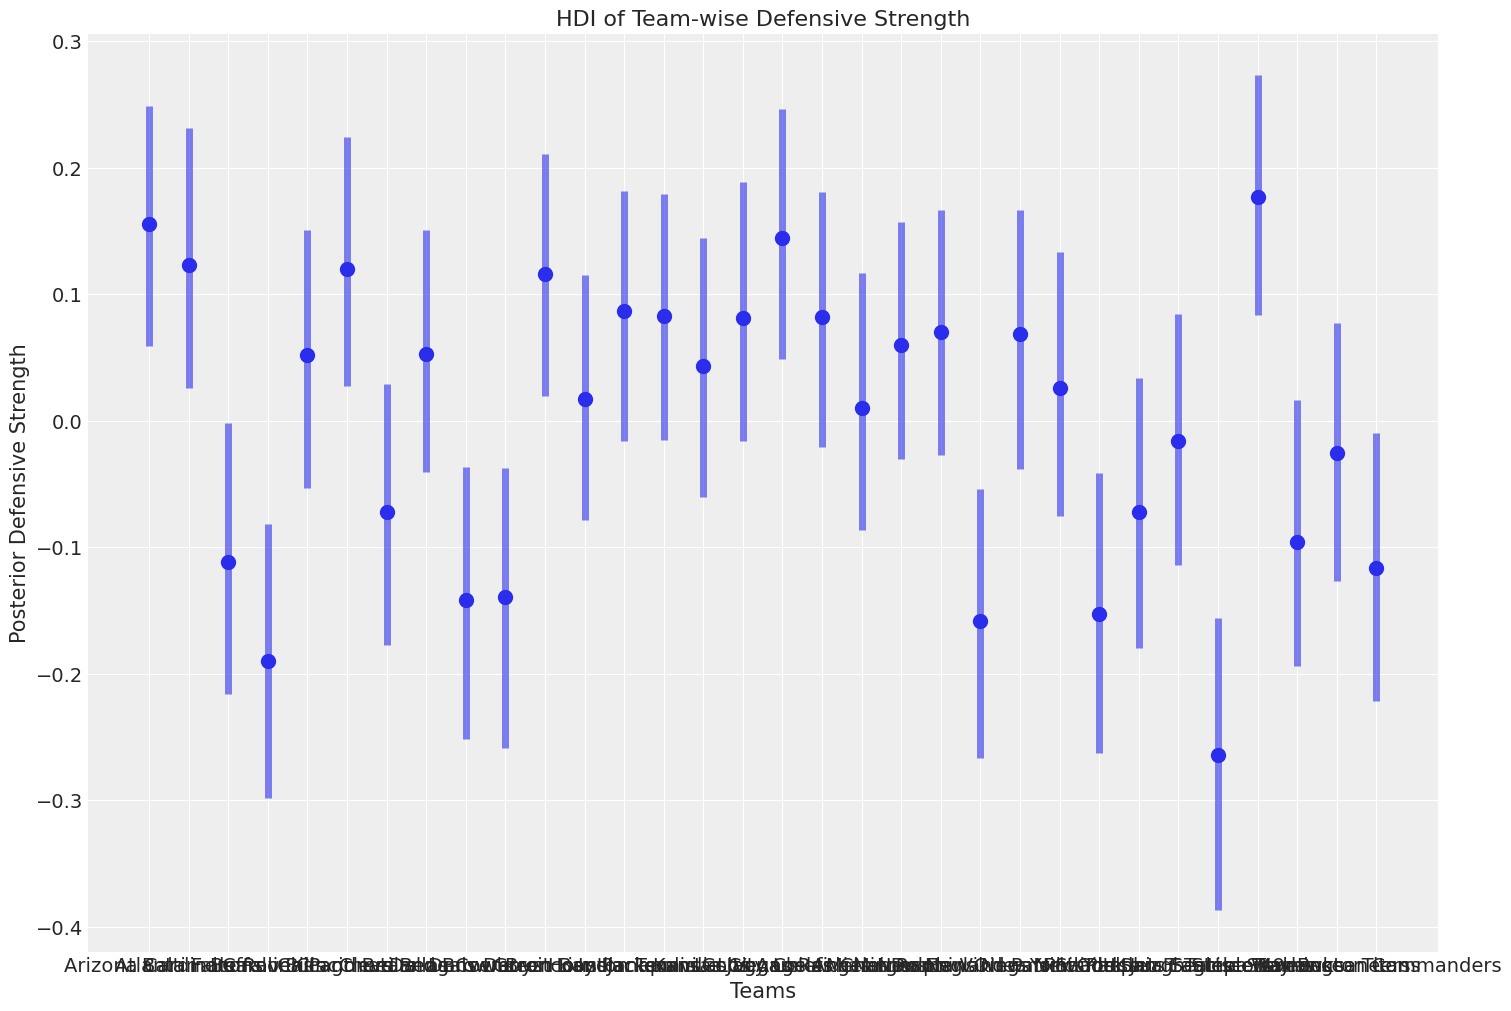

In [20]:
_, ax = plt.subplots(figsize=(15, 10))

ax.scatter(teams, trace.posterior["defenses"].median(dim=("chain", "draw")), color="C0", alpha=1, s=100)
ax.vlines(
    teams,
    trace_hdi["defenses"].sel({"hdi": "lower"}),
    trace_hdi["defenses"].sel({"hdi": "higher"}),
    alpha=0.6,
    lw=5,
    color="C0",
)
ax.set_xlabel("Teams")
ax.set_ylabel("Posterior Defensive Strength")
ax.set_title("HDI of Team-wise Defensive Strength");

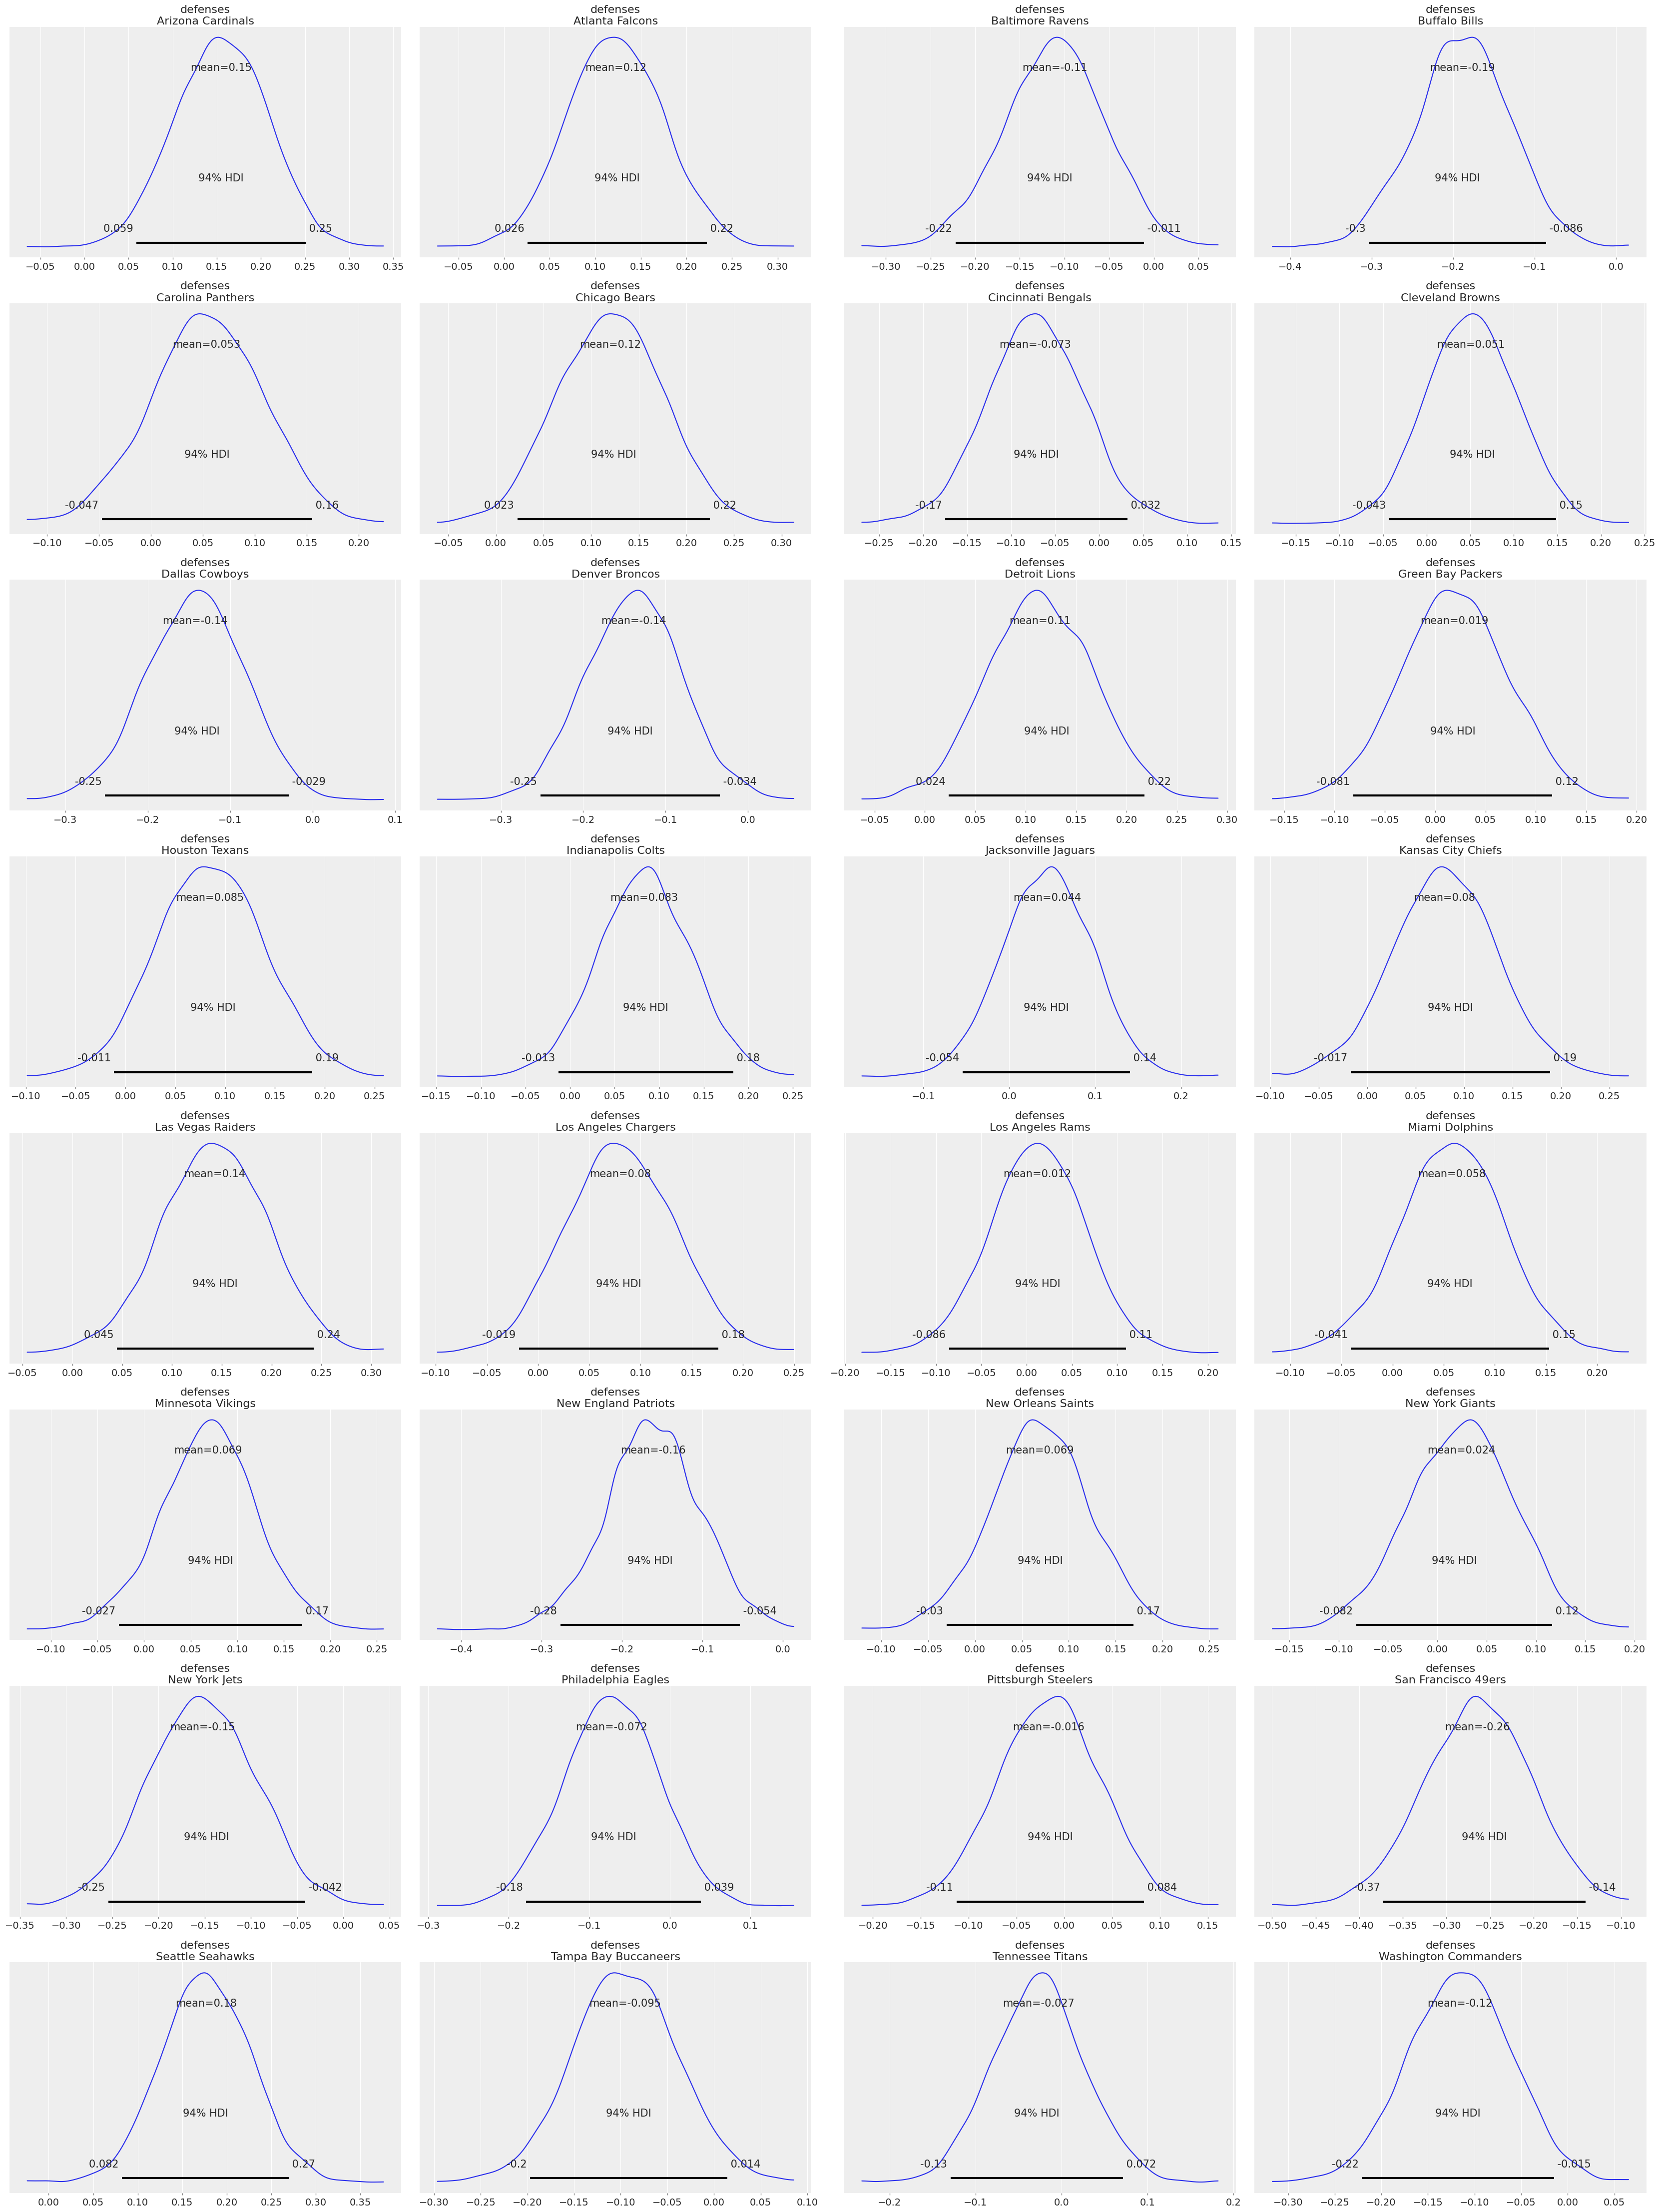

In [49]:
az.plot_posterior(trace, var_names=["defenses"]);

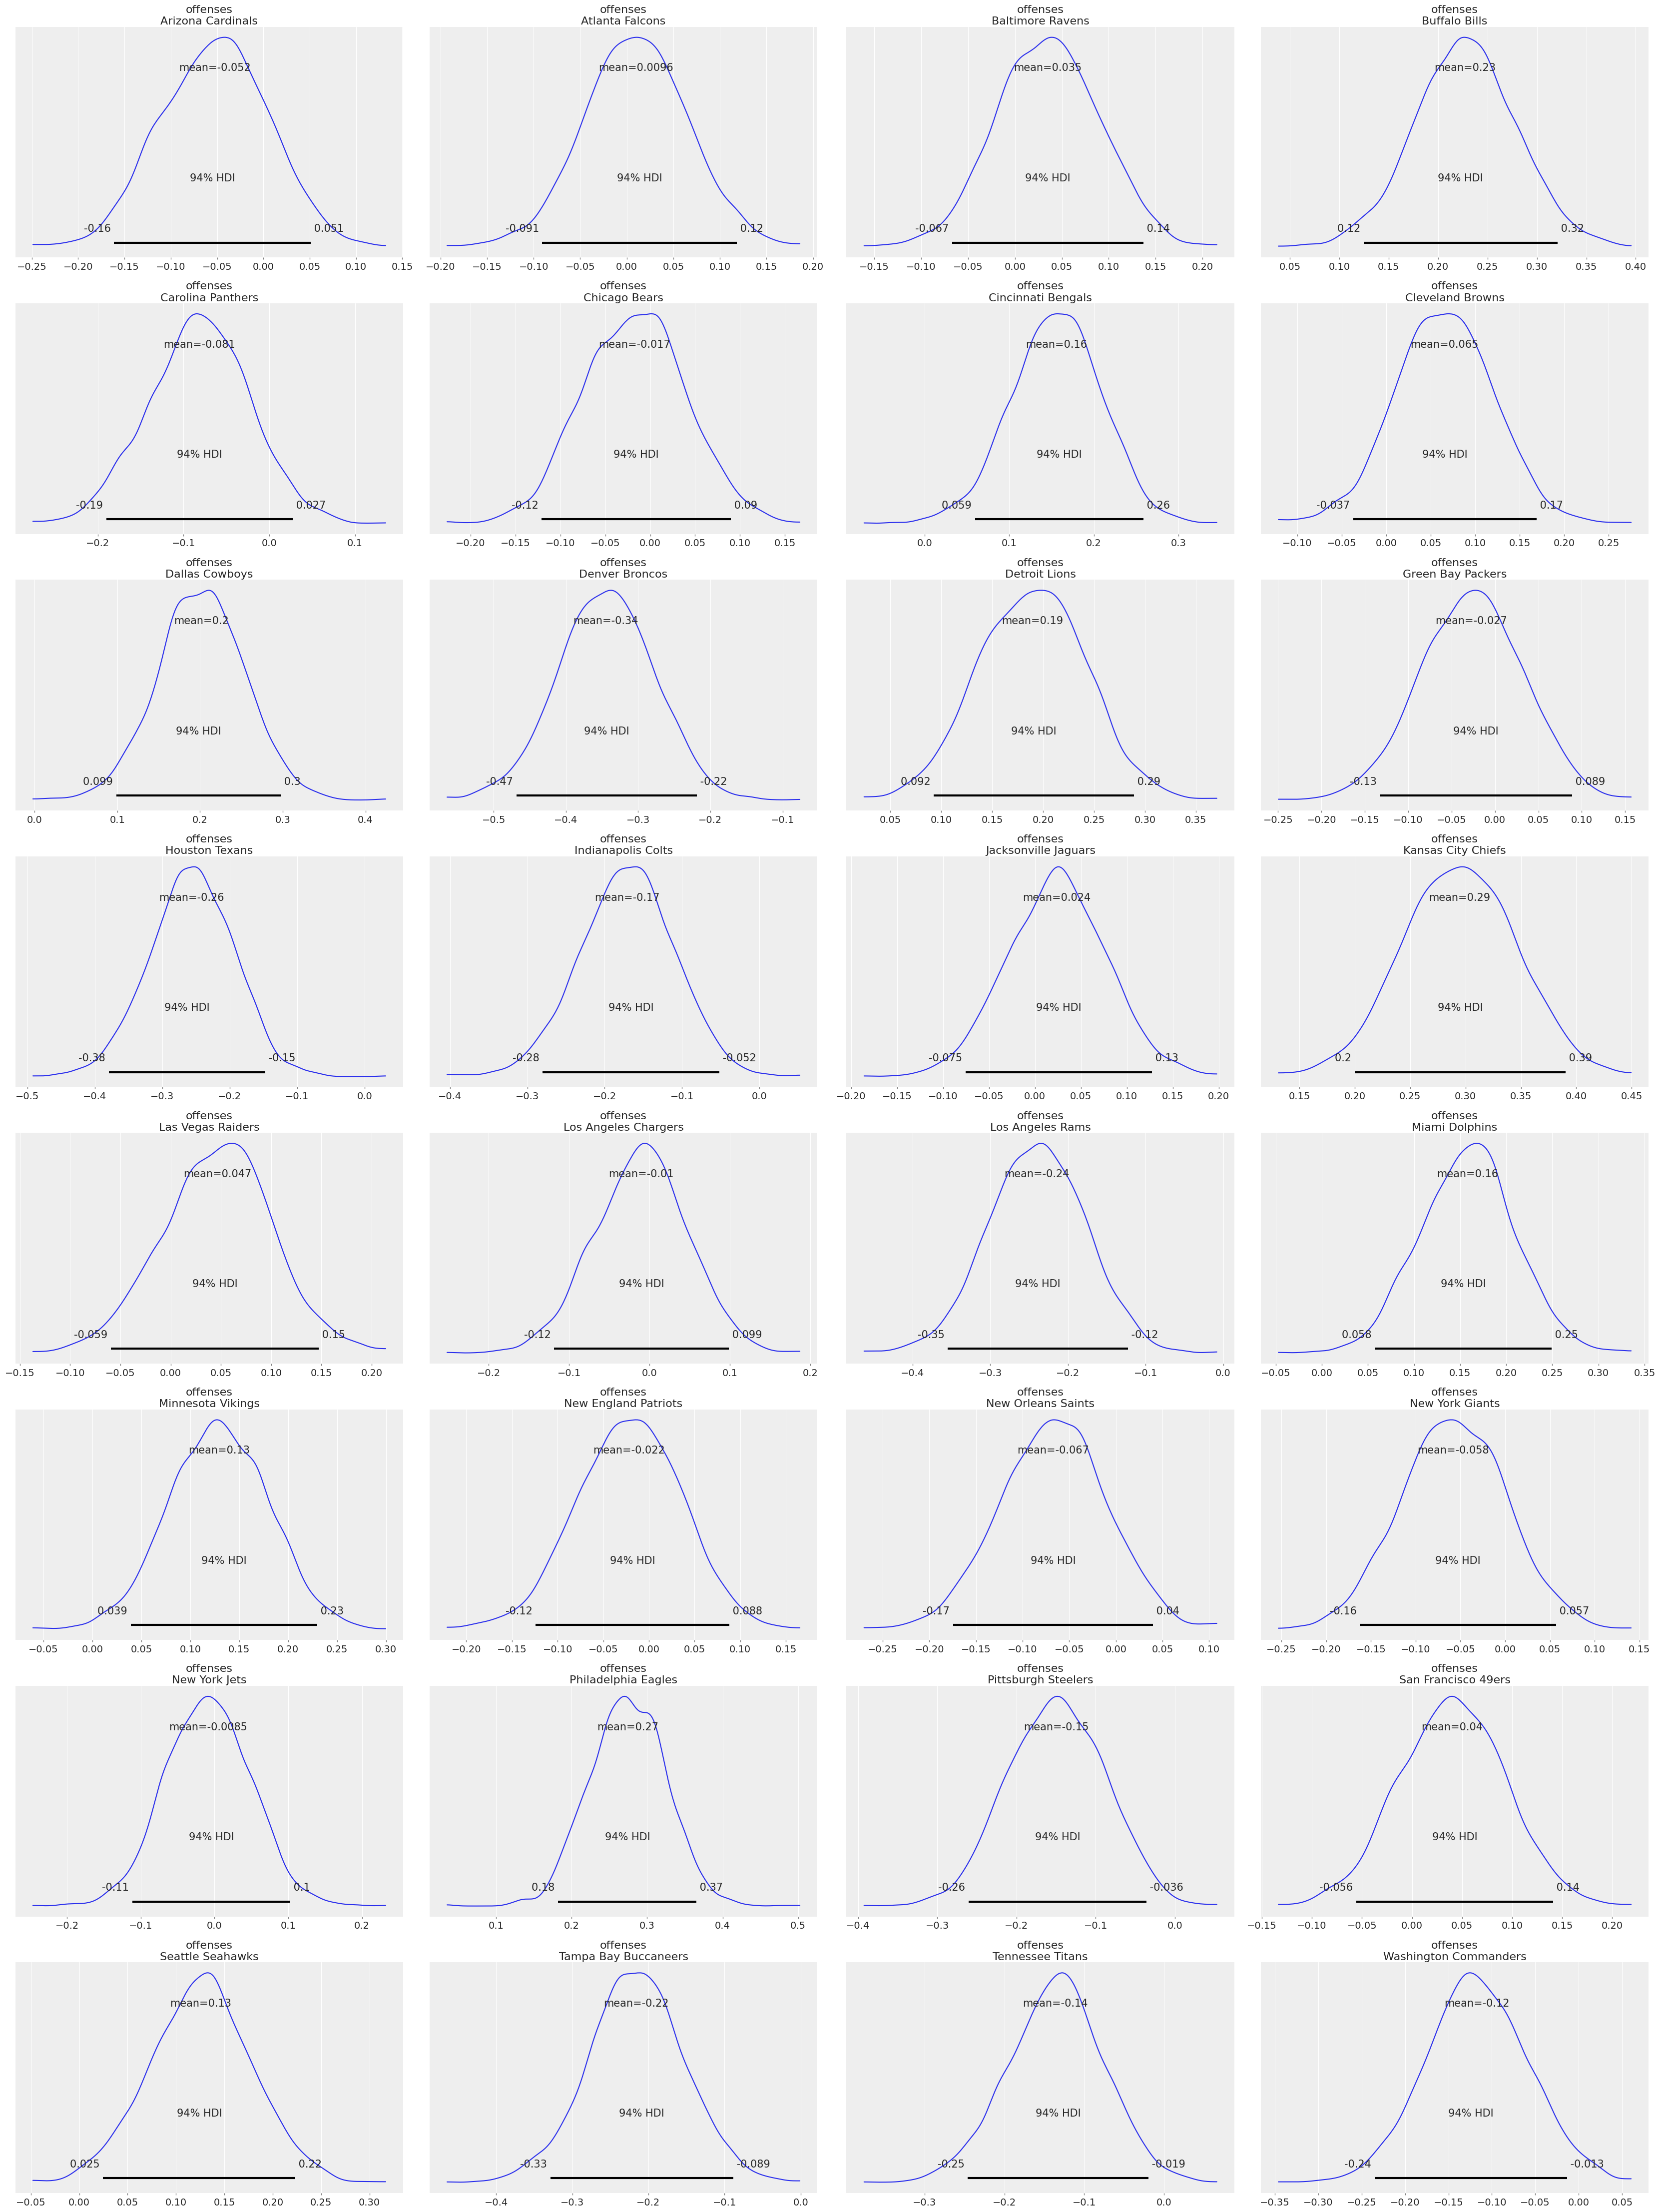

In [50]:
az.plot_posterior(trace, var_names=["offenses"]);

## Simulations

In [57]:
team_idx_map, i = {}, 0
for team in teams: 
  team_idx_map[team] = i
  i += 1
team_idx_map        #making a dictionary that maps team name to id number

{'Arizona Cardinals': 0,
 'Atlanta Falcons': 1,
 'Baltimore Ravens': 2,
 'Buffalo Bills': 3,
 'Carolina Panthers': 4,
 'Chicago Bears': 5,
 'Cincinnati Bengals': 6,
 'Cleveland Browns': 7,
 'Dallas Cowboys': 8,
 'Denver Broncos': 9,
 'Detroit Lions': 10,
 'Green Bay Packers': 11,
 'Houston Texans': 12,
 'Indianapolis Colts': 13,
 'Jacksonville Jaguars': 14,
 'Kansas City Chiefs': 15,
 'Las Vegas Raiders': 16,
 'Los Angeles Chargers': 17,
 'Los Angeles Rams': 18,
 'Miami Dolphins': 19,
 'Minnesota Vikings': 20,
 'New England Patriots': 21,
 'New Orleans Saints': 22,
 'New York Giants': 23,
 'New York Jets': 24,
 'Philadelphia Eagles': 25,
 'Pittsburgh Steelers': 26,
 'San Francisco 49ers': 27,
 'Seattle Seahawks': 28,
 'Tampa Bay Buccaneers': 29,
 'Tennessee Titans': 30,
 'Washington Commanders': 31}

In [56]:
idx_team_map, i = {}, 0
for team in teams: 
  idx_team_map[i] = team
  i += 1
idx_team_map        #making a dictionary that maps id number to team name

{0: 'Arizona Cardinals',
 1: 'Atlanta Falcons',
 2: 'Baltimore Ravens',
 3: 'Buffalo Bills',
 4: 'Carolina Panthers',
 5: 'Chicago Bears',
 6: 'Cincinnati Bengals',
 7: 'Cleveland Browns',
 8: 'Dallas Cowboys',
 9: 'Denver Broncos',
 10: 'Detroit Lions',
 11: 'Green Bay Packers',
 12: 'Houston Texans',
 13: 'Indianapolis Colts',
 14: 'Jacksonville Jaguars',
 15: 'Kansas City Chiefs',
 16: 'Las Vegas Raiders',
 17: 'Los Angeles Chargers',
 18: 'Los Angeles Rams',
 19: 'Miami Dolphins',
 20: 'Minnesota Vikings',
 21: 'New England Patriots',
 22: 'New Orleans Saints',
 23: 'New York Giants',
 24: 'New York Jets',
 25: 'Philadelphia Eagles',
 26: 'Pittsburgh Steelers',
 27: 'San Francisco 49ers',
 28: 'Seattle Seahawks',
 29: 'Tampa Bay Buccaneers',
 30: 'Tennessee Titans',
 31: 'Washington Commanders'}

In [58]:
pairings = {'home_team' : ['Denver Broncos', 'Las Vegas Raiders', 'Tampa Bay Buccaneers', 'Los Angeles Chargers', 'Washington Commanders'], 'away_team' : ['Arizona Cardinals', 'New England Patriots', 'Cincinnati Bengals', 'Tennessee Titans', 'New York Giants']}
final = {'home_team' : [], 'away_team' : []}

for team in pairings: 
  for name in pairings[team]: 
    final[team].append(team_idx_map[name])

pairs_df = pd.DataFrame.from_dict(final)      #making pairs_df have the games from this Sunday evening/night
pairs_df                                  

,home_team,away_team
0,9,0
1,16,21
2,29,6
3,17,30
4,31,23


In [59]:
with model: 
  pm.set_data({"home_team" : pairs_df["home_team"], "away_team" : pairs_df["away_team"]})
  posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["home_points", "away_points"])
  print(posterior_predictive)           #doing posterior predictive check

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data


In [63]:
wins = {}
scores = {}
over_under = {'Tampa Bay Buccaneers' : [], 'Los Angeles Chargers' : [], 'Denver Broncos' : [], 'Las Vegas Raiders' : [], 'Washington Commanders' : []}
for chain in [0, 1, 2, 3]: 
  for draw in range(1000):
    for game in range(5):

      home_points = int(posterior_predictive['posterior_predictive']['home_points'][chain][draw][game])   #all games for that chain and draw
      away_points = int(posterior_predictive['posterior_predictive']['away_points'][chain][draw][game])
      home_team_idx = int(posterior_predictive['constant_data']['home_team'][game])
      away_team_idx = int(posterior_predictive['constant_data']['away_team'][game])
      home_team = idx_team_map[home_team_idx]
      away_team = idx_team_map[away_team_idx]
      if home_team == 'Tampa Bay Buccaneers':
        if home_points + away_points < 47:
          over_under[home_team].append(1)
        else: 
          over_under[home_team].append(0)
      elif home_team == 'Los Angeles Chargers':
        if home_points + away_points < 46.5:
          over_under[home_team].append(1)
        else: 
          over_under[home_team].append(0)   
      elif home_team == 'Washington Commanders':
        if home_points + away_points < 40.5:
          over_under[home_team].append(1)
        else: 
          over_under[home_team].append(0)  
      elif home_team == 'Denver Broncos':
        if home_points + away_points < 37:
          over_under[home_team].append(1)
        else: 
          over_under[home_team].append(0)  
      elif home_team == 'Las Vegas Raiders':
        if home_points + away_points < 45:            #calculating if the under hit in the over/under
          over_under[home_team].append(1)
        else: 
          over_under[home_team].append(0) 

      if home_points > away_points: 
        try:
          wins[home_team].append(1)
        except: 
          wins[home_team] = [1]
        try:
          wins[away_team].append(0)
        except: 
          wins[away_team] = [0]
      elif home_points < away_points: 
        try: 
          wins[home_team].append(0)
        except: 
          wins[home_team] = [0]
        try: 
          wins[away_team].append(1)
        except: 
          wins[away_team] = [1]
      else: 
        try: 
          wins[home_team].append(.5)
        except: 
          wins[home_team] = [.5]
        try:                                              #calculating who won
          wins[away_team].append(.5)
        except: 
          wins[away_team] = [.5]

      try: 
        scores[home_team].append(home_points)
      except: 
        scores[home_team] = [home_points]           #documenting the score of the game
      try: 
        scores[away_team].append(away_points)
      except: 
        scores[away_team] = [away_points]       #analyzing all the simulated games (all these games happened Sunday night on 12/18)

  print('Done with chain : ', str(chain))

Done with chain :  0
Done with chain :  1
Done with chain :  2
Done with chain :  3


In [65]:
for team in wins: 
  print(str(team) + str(np.mean(wins[team])))     #printing the winning percentage of each team in the simulation (each consecutive two teams played each other; i.e., DEN vs ARI, LVR vs NE)
                                                  #these predictions went 3-2 on one of the craziest evenings of NFL football ever

Denver Broncos0.58825
Arizona Cardinals0.41175
Las Vegas Raiders0.301625
New England Patriots0.698375
Tampa Bay Buccaneers0.211875
Cincinnati Bengals0.788125
Los Angeles Chargers0.60275
Tennessee Titans0.39725
Washington Commanders0.688625
New York Giants0.311375


In [67]:
avg_scores = {}
for team in scores: 
  avg_scores[team] = np.mean(scores[team])
avg_scores      #printing the average scores of each team in the simulation (each consecutive two teams played each other; i.e., DEN vs ARI, LVR vs NE)

{'Denver Broncos': 18.586,
 'Arizona Cardinals': 17.19025,
 'Las Vegas Raiders': 20.02775,
 'New England Patriots': 23.54575,
 'Tampa Bay Buccaneers': 16.79025,
 'Cincinnati Bengals': 22.0235,
 'Los Angeles Chargers': 21.62875,
 'Tennessee Titans': 19.8015,
 'Washington Commanders': 20.71675,
 'New York Giants': 17.50675}

In [70]:
games = {'Denver Broncos' : 'Arizona Cardinals', 'Las Vegas Raiders' : 'New England Patriots', 'Tampa Bay Buccaneers' : 'Cincinnati Bengals', 'Los Angeles Chargers' : 'Tennessee Titans', 'Washington Commanders' : 'New York Giants'}
for team in over_under: 
  print(str(team) + ' vs ' + str(games[team]) + ', probability of under hitting : ' + str(np.mean(over_under[team])))
                      #printing the odds of the over/under for each game (went 2-3 with these predictions)

Tampa Bay Buccaneers vs Cincinnati Bengals, probability of under hitting : 0.87925
Los Angeles Chargers vs Tennessee Titans, probability of under hitting : 0.77425
Denver Broncos vs Arizona Cardinals, probability of under hitting : 0.55525
Las Vegas Raiders vs New England Patriots, probability of under hitting : 0.56775
Washington Commanders vs New York Giants, probability of under hitting : 0.64725
